# **Slide-seq lung: single-cell reference data processing**

In [56]:
import os
import json
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplscience

BASE_PATH = "/home/projects/nyosef/oier/Harreman_files/Slide_seq_lung"
SC_REF_PATH = os.path.join(BASE_PATH, 'sc_reference')
ADATA_PATH = os.path.join(BASE_PATH, 'h5ads')
DATA_PATH = os.path.join(BASE_PATH, 'data')
PLOTS_PATH = os.path.join(BASE_PATH, 'plots')

## Load dataset

The data was obtained from https://singlecell.broadinstitute.org/single_cell/study/SCP1288/tumor-and-immune-reprogramming-during-immunotherapy-in-advanced-renal-cell-carcinoma#/.

In [2]:
adata = sc.read_mtx(os.path.join(SC_REF_PATH, 'SCP1288/expression/60c76a18771a5b0ba10ea91b/matrix.mtx.gz')).T
barcodes = pd.read_csv(os.path.join(SC_REF_PATH, 'SCP1288/expression/60c76a18771a5b0ba10ea91b/barcodes.tsv.gz'), sep="\t", compression="gzip", index_col=0, header=None).index.tolist()
features = pd.read_csv(os.path.join(SC_REF_PATH, 'SCP1288/expression/60c76a18771a5b0ba10ea91b/features.tsv.gz'), sep="\t", compression="gzip", index_col=0, header=None).index.tolist()

adata.obs_names = barcodes
adata.var_names = features

In [ ]:
adata

AnnData object with n_obs × n_vars = 39391 × 60627

In [4]:
metadata_df = pd.read_csv(os.path.join(SC_REF_PATH, 'SCP1288/metadata/Final_SCP_Metadata.txt'), sep="\t", index_col=0)
cluster_df = pd.read_csv(os.path.join(SC_REF_PATH, 'SCP1288/cluster/Final_SCP_ClusterFile.txt'), sep="\t", index_col=0)

/tmp/ipykernel_3318426/1347882957.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(os.path.join(SC_REF_PATH, 'SCP1288/metadata/Final_SCP_Metadata.txt'), sep="\t", index_col=0)


In [7]:
cluster_df = cluster_df.drop('TYPE', axis=0)
metadata_df = metadata_df.drop('TYPE', axis=0)

In [5]:
adata.obs[metadata_df.columns] = metadata_df
adata = adata[adata.obs.dropna().index].copy()

In [6]:
adata.layers['counts'] = adata.X.copy()

In [7]:
cell_type_dict = {
    '41BB-Hi CD8+ T cell': 'CD8+ T cell', 
    '41BB-Lo CD8+ T cell': 'CD8+ T cell', 
    'B cell': 'B cell', 
    'CD1C+ DC': 'DC',
    'CD16+ Monocyte': 'Monocyte', 
    'CD16- Monocyte': 'Monocyte', 
    'CLEC9A+ DC': 'DC', 
    'CXCL10-Hi TAM': 'TAM',
    'Cycling CD8+ T cell': 'CD8+ T cell', 
    'Cycling TAM': 'TAM', 
    'Cycling Tumor': 'Tumor',
    'Effector T-Helper': 'T-Helper', 
    'Endothelial': 'Endothelial', 
    'FGFBP2+ NK': 'NK', 
    'FGFBP2- NK': 'NK',
    'FOLR2-Hi TAM': 'TAM', 
    'Fibroblast': 'Fibroblast', 
    'GPNMB-Hi TAM': 'TAM', 
    'LowLibSize Macrophage': 'TAM',
    'MX1-Hi CD8+ T cell': 'CD8+ T cell', 
    'Mast cell': 'Mast cell', 
    'Memory T-Helper': 'T-Helper',
    'Misc/Undetermined': 'Misc/Undetermined', 
    'MitoHigh CD8+ T cell': 'CD8+ T cell', 
    'MitoHigh Myeloid': 'TAM',
    'MitoHigh NK': 'NK', 
    'MitoHigh T-Helper': 'T-Helper', 
    'NKT': 'NKT', 
    'Plasma cell': 'Plasma cell', 
    'T-Reg': 'T-Reg',
    'TP1': 'Tumor', 
    'TP2': 'Tumor', 
    'VSIR-Hi TAM': 'TAM',
}

In [8]:
adata.obs['cell_type_coarse'] = adata.obs['FinalCellType'].apply(lambda x: cell_type_dict[x])

In [9]:
del adata.obs['Initial_Louvain_Cluster']

We save the AnnData

In [10]:
# adata.write(os.path.join(ADATA_PATH, 'Slide_seq_lung_sc_ref_adata.h5ad'))

In [46]:
adata = sc.read_h5ad(os.path.join(ADATA_PATH, 'Slide_seq_lung_sc_ref_adata.h5ad'))

In [47]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [48]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="donor_id")

In [49]:
sc.tl.pca(adata)

In [50]:
sc.pp.neighbors(adata)

In [51]:
sc.tl.umap(adata)

In [60]:
adata = sc.read_h5ad(os.path.join(ADATA_PATH, 'Slide_seq_lung_sc_ref_scVI_adata.h5ad'))

In [61]:
palette = {
  'B cell': '#1F78B4',
  'Plasma cell': '#A6CEE3',
  'T-Helper': "#FF7F00",
  'T-Reg': "#FDBF6F",
  'CD8+ T cell': "#B15928",
  'NK': "#33A02C",
  'NKT': "#B2DF8A",
  'TAM': "#A50F15",
  'Monocyte': "#E31A1C",
  'DC': "#ff9896",
  'Mast cell': "#FFFF99",
  'Fibroblast': "#6A3D9A",
  'Endothelial': "#CAB2D6",
  'Tumor': "#C51B7D",
  'Misc/Undetermined': "#D3D3D3",
}

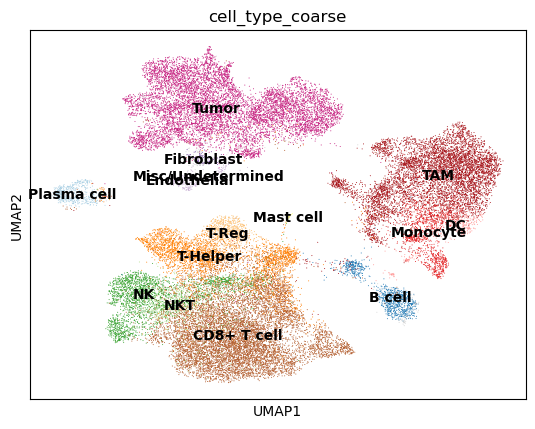

In [62]:
sc.pl.umap(
    adata,
    color="cell_type_coarse",
    palette=palette,
    size=2,
    legend_loc='on data'
)

In [63]:
# sc.pl.umap(adata, color="cell_type_coarse", palette=palette, size=2, title='', show=False)
# plt.savefig(os.path.join(PLOTS_PATH, 'sc_reference_umap.pdf'), bbox_inches='tight')
# plt.close()